In [1]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [2]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [3]:
tiny_ceo_df = ceo_df[ceo_df['size_category'] == 'Tiny']
medium_ceo_df = ceo_df[ceo_df['size_category'] == 'Medium']
big_ceo_df = ceo_df[ceo_df['size_category'] == 'Big']
huge_ceo_df = ceo_df[ceo_df['size_category'] == 'Huge']

tiny_bod_df = bod_df[bod_df['size_category'] == 'Tiny']
medium_bod_df = bod_df[bod_df['size_category'] == 'Medium']
big_bod_df = bod_df[bod_df['size_category'] == 'Big']
huge_bod_df = bod_df[bod_df['size_category'] == 'Huge']



list_ceo_df = [tiny_ceo_df, medium_ceo_df, big_ceo_df, huge_ceo_df]
list_bod_df = [tiny_bod_df, medium_bod_df, big_bod_df, huge_bod_df]

In [4]:
df = medium_ceo_df
df.drop(['Unnamed: 0', 'gvkey'], axis=1, inplace=True)
df.drop('ownershipratio', axis=1, inplace=True)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['year'] >= 2010) & (df['year'] <= 2016)]
holdout_mask = df.loc[(df['year'] >= 2017) & (df['year'] <= 2019)]

y = np.log(train_mask.tdc1)
X = train_mask.drop('tdc1', axis=1)

VarY = holdout_mask[['signature_index', 'tdc1']]
VarY.to_csv('Saved/medium_ceo_df.csv', index=False)
VarY = pd.read_csv('./Saved/medium_ceo_df.csv')


holdout_X = VarY.drop(['signature_index'], axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)



/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_3030/2339433354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0', 'gvkey'], axis=1, inplace=True)
/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_3030/2339433354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('ownershipratio', axis=1, inplace=True)


In [5]:
cv = KFold(5)

In [6]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['gender']),
    remainder="drop",
)
# pipe = Pipeline([('columntransformer',preproc_pipe),
#                  ('feature_select',SelectKBest()), 
#                  ('clf', Ridge())
#                 ])

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [7]:
alphas = list(np.linspace(0, 300, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

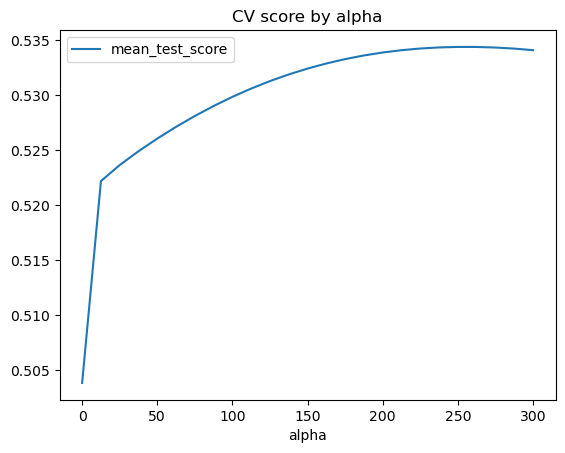

In [8]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

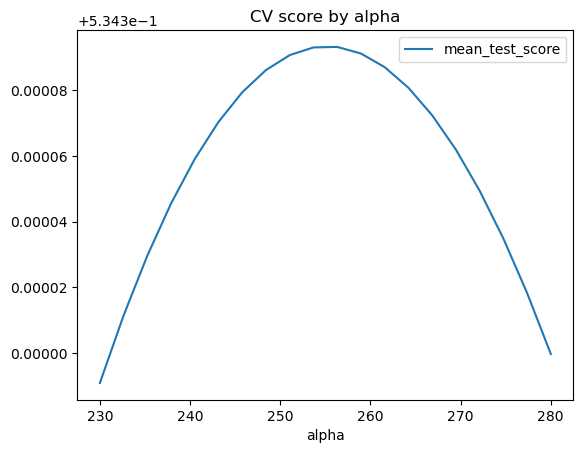

In [9]:
alphas = list(np.linspace(230, 280,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2387 entries, 0 to 10821
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticker           2387 non-null   object 
 1   salary           2387 non-null   float64
 2   bonus            2387 non-null   float64
 3   stock_awards     2387 non-null   float64
 4   option_awards    2387 non-null   float64
 5   othcomp          2387 non-null   float64
 6   total_curr       2387 non-null   float64
 7   age              2387 non-null   float64
 8   tdc1             2387 non-null   float64
 9   year             2387 non-null   int64  
 10  becameceo        2333 non-null   float64
 11  joined_co        568 non-null    float64
 12  leftofc          1439 non-null   float64
 13  gender           2387 non-null   object 
 14  cusip            2387 non-null   int64  
 15  naicsdesc        2387 non-null   int64  
 16  sic              2387 non-null   int64  
 17  mkvalt       

In [11]:
##### 0.00184
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 256.31579


In [12]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: 0.53439


In [13]:
cv = KFold(10)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    (cat_pipe, ['gender']),
    remainder="drop",
)


In [14]:
pipe = Pipeline([('columntransformer',preproc_pipe),
                 ('feature_select',SelectKBest()), 
                 ('clf', Ridge()),
                ])

In [15]:
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)


# param_grid = {
#     'feature_select__k': [3, 5,7, 8, 9, 10, 12, 13],
#     'clf__alpha': [0, 50, 100, 150, 200, 250, 300, 350], 
    
# }

# # hyperparameters chosen: k in SelectKBest and C in LogisticRegression

# grid_search = GridSearchCV(estimator = pipe, 
#                            param_grid = param_grid,
#                            cv = cv, #KFold(10) 
#                            scoring='r2', 
#                            error_score='raise'
#                            )

# results = grid_search.fit(X_train,y_train)

from sklearn.feature_selection import SelectPercentile, f_regression

pipe = Pipeline([('columntransformer',preproc_pipe),
                 ('feature_select',SelectPercentile(score_func=f_regression)), 
                 ('clf', Ridge())
                ])

param_grid = {
    # 'feature_select__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'feature_select__percentile': [90, 91, 92, 93, 94, 95, 96, 97],

    # 'clf__alpha': [0, 50, 100, 150, 200, 250, 300, 350], 
    'clf__alpha': [246, 247, 248, 249, 250, 251, 252, 253], 

}

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)


In [16]:
results_data = pd.DataFrame(results.cv_results_)
results_data = results_data[['params','mean_test_score','std_test_score']]
results_data['alpha'] = results_data['params'].apply(lambda x: x.get('clf__alpha'))
results_data['k'] = results_data['params'].apply(lambda x: x.get('feature_select__percentile'))
results_data

,params,mean_test_score,std_test_score,alpha,k
0,"{'clf__alpha': 246, 'feature_select__percentil...",0.533001,0.154904,246,90
1,"{'clf__alpha': 246, 'feature_select__percentil...",0.533001,0.154904,246,91
2,"{'clf__alpha': 246, 'feature_select__percentil...",0.533001,0.154904,246,92
3,"{'clf__alpha': 246, 'feature_select__percentil...",0.533001,0.154904,246,93
4,"{'clf__alpha': 246, 'feature_select__percentil...",0.533001,0.154904,246,94
...,...,...,...,...,...
59,"{'clf__alpha': 253, 'feature_select__percentil...",0.533023,0.153229,253,93
60,"{'clf__alpha': 253, 'feature_select__percentil...",0.533023,0.153229,253,94
61,"{'clf__alpha': 253, 'feature_select__percentil...",0.536614,0.152343,253,95
62,"{'clf__alpha': 253, 'feature_select__percentil...",0.536614,0.152343,253,96


Text(5    0.15397
Name: std_test_score, dtype: float64, 5    0.536621
Name: mean_test_score, dtype: float64, 'Best params: k=95, alpha=246     ')

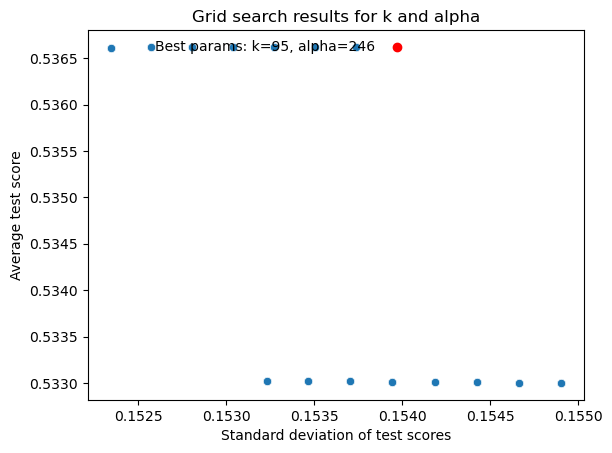

In [17]:
sns.scatterplot(data=results_data, x='std_test_score', y='mean_test_score')
plt.xlabel('Standard deviation of test scores')
plt.ylabel('Average test score')
plt.title('Grid search results for k and alpha')

best_params = grid_search.best_params_
best_k = best_params['feature_select__percentile']
best_alpha = best_params['clf__alpha']
plt.scatter(x=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'], 
            y=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'mean_test_score'], color='red')
plt.text(results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'],
         results_data.loc[(results_data['k'] == best_k) 
                                & (results_data['alpha'] == best_alpha),
                                'mean_test_score'], 
         f"Best params: k={best_k}, alpha={best_alpha}     ", ha='right', va='center')

In [18]:
opt_pipe = make_pipeline(preproc_pipe, SelectKBest(f_classif, k=best_k), Ridge(alpha=best_alpha))
opt_pipe.fit(X_train, y_train)

y_holdout_pred = opt_pipe.predict(holdout_X)

# create a dataframe with the parcel ID and the predicted values
df_out = pd.DataFrame({'signature_index': VarY['signature_index'], 'prediction': y_holdout_pred })

ValueError: k should be >=0, <= n_features = 20; got 95. Use k='all' to return all features.